In [1]:
# packages

# JAX
import jax.numpy as jnp
from jax import grad, vmap, hessian

# Numpy
import numpy as onp
from numpy import random 

# Scipy
import scipy.sparse
from scipy.sparse import diags
from scipy.interpolate import griddata

# Plot
import matplotlib.pyplot as plt

Inverse problems: Darcy flow
\begin{equation*}
\begin{aligned}
& -\nabla \cdot (a \nabla u)=f, x \in [0,1]^2\\
& u=0 \text{ on boundary}\\
\end{aligned}
\end{equation*}
We know $f=1$, and $u(x_i)$ at some points in the domain. Our target is to recover both $u$ and $a$. 

In [2]:
# fix random seeds, for generating reference solution & sampled points
random.seed(20)

# a(x,y)
def a(x1, x2):
    c=1
    return jnp.exp(c*jnp.sin(2*jnp.pi*x1)+c*jnp.sin(2*jnp.pi*x2))+jnp.exp(-c*jnp.sin(2*jnp.pi*x1)-c*jnp.sin(2*jnp.pi*x2))

# boundary value
def u(x1, x2):
    return 0

# right hand side
def f(x1, x2):
    return 1

In [3]:
# provide a numerical reference solution for this PDE
# Finite Difference Method [0,1]*[0,1]
# N interior grid points

def FD_Darcy_flow_2d(N):
    hg = 1/(N+1)
    x_mid = (onp.arange(0,N+1,1)+0.5)*hg
    x_grid = (onp.arange(1,N+1,1))*hg
    mid, grid = onp.meshgrid(x_mid, x_grid)
    a1 = onp.reshape(vmap(a)(mid.flatten(), grid.flatten()), (N, N+1))
    a2 = onp.transpose(onp.reshape(vmap(a)(grid.flatten(), mid.flatten()), (N,N+1)))

    # diagonal element of A
    a_diag = onp.reshape(a1[:,:N]+a1[:,1:]+a2[:N,:]+a2[1:,:], (1,-1))
    
    # off-diagonals
    a_super1 = onp.reshape(onp.append(a1[:,1:N], onp.zeros((N,1)), axis = 1), (1,-1))
    a_super2 = onp.reshape(a2[1:N,:], (1,-1))
    
    A = diags([[-a_super2[onp.newaxis, :]], [-a_super1[onp.newaxis, :]], [a_diag], [-a_super1[onp.newaxis, :]], [-a_super2[onp.newaxis, :]]], [-N,-1,0,1,N], shape=(N**2, N**2))/(hg**2)
    
    XX, YY = onp.meshgrid(x_grid, x_grid)
    fv = vmap(f)(XX.flatten(), YY.flatten())
    fv = fv[:, onp.newaxis]
    sol_u = scipy.sparse.linalg.spsolve(A, fv)

    
    return sol_u


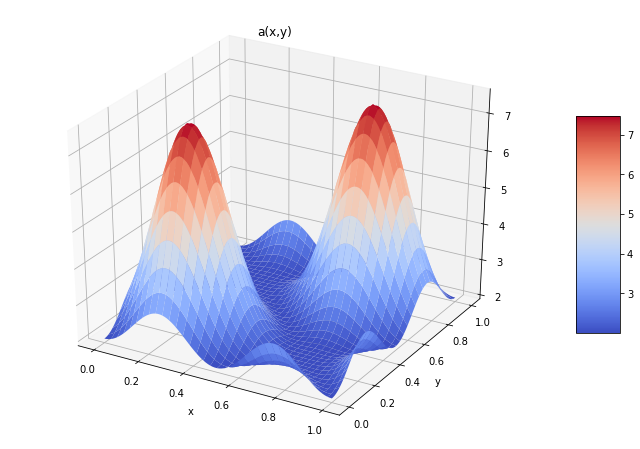

/Users/yifanc/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


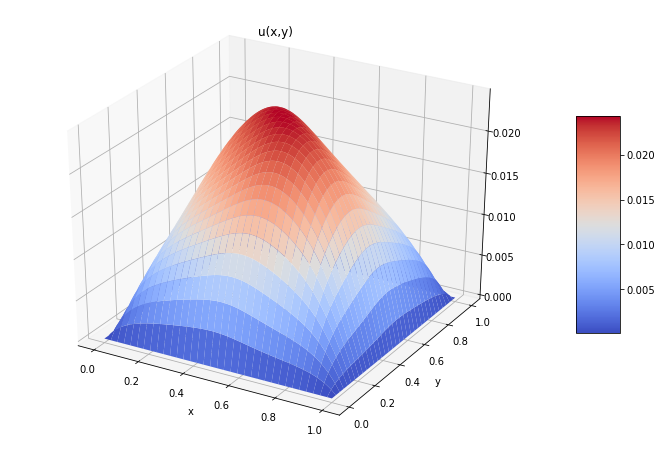

In [4]:
# plot the solution a(x,y)

def plot_a(num_pts):
    xx = onp.linspace(0, 1, num_pts+2)
    yy = onp.linspace(0, 1, num_pts+2)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = onp.array(XX.flatten())
    YYv = onp.array(YY.flatten())
    ZZ_a = vmap(a)(XXv, YYv)
    ZZ_a = ZZ_a.reshape(num_pts+2,num_pts+2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    a_surf=ax.plot_surface(XX, YY, ZZ_a, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('a(x,y)')
    
    fig.colorbar(a_surf, shrink= 0.5, aspect = 5)
    plt.show()
    return XX, YY, ZZ_a

    
def plot_u(num_pts):
    sol_u = FD_Darcy_flow_2d(num_pts)
    sol_u = onp.reshape(sol_u, (num_pts, num_pts))
    sol_u_plus_bd = onp.zeros((num_pts+2,num_pts+2))
    sol_u_plus_bd[1:num_pts+1,1:num_pts+1]=sol_u
    
    xx = onp.linspace(0, 1, num_pts+2)
    yy = onp.linspace(0, 1, num_pts+2)
    XX, YY = onp.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    u_surf=ax.plot_surface(XX, YY, sol_u_plus_bd, cmap=plt.cm.coolwarm)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('u(x,y)')
    
    fig.colorbar(u_surf, shrink= 0.5, aspect = 5)
    plt.show()
    
    return XX, YY, sol_u_plus_bd

XX, YY, ZZ_a = plot_a(100)
XX, YY, u_true = plot_u(100)

XXv = onp.array(XX.flatten())
YYv = onp.array(YY.flatten())
u_true_vec = onp.reshape(u_true, (-1,1))

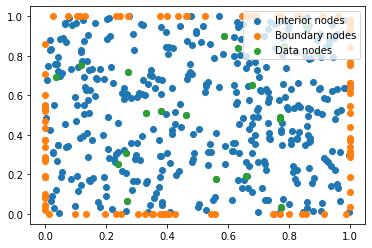

In [5]:
def sample_points(N_domain, N_boundary, N_data):
    # interior nodes
    X_domain = random.uniform(0.0, 1.0, (N_domain, 2))
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 

    # bottom face
    X_boundary[range(int(N_boundary/4)), 0] = random.uniform(0.0, 1.0, int(N_boundary/4))
    # right face
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 0] += 1
    X_boundary[range(int(N_boundary/4), 2*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    # top face
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 0] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    X_boundary[range(2*int(N_boundary/4), 3*int(N_boundary/4)), 1] += 1
    # left face
    X_boundary[range(3*int(N_boundary/4), 4*int(N_boundary/4)), 1] = \
        random.uniform(0.0, 1.0, int(N_boundary/4))
    
    data_index = onp.array(range(N_data))
    return X_domain, X_boundary, data_index

N_domain_tot = 400
N_boundary_tot = 100
N_data_tot = 20
X_domain_tot, X_boundary_tot, data_index_tot = sample_points(N_domain_tot, N_boundary_tot, N_data_tot)


fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 0], X_domain_tot[range(N_domain_tot), 1], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 0], X_boundary_tot[range(N_boundary_tot), 1], label='Boundary nodes')
ax.scatter(X_domain_tot[data_index_tot, 0], X_domain_tot[data_index_tot, 1], label='Data nodes')
    
ax.legend(loc="upper right")
plt.show()

In [6]:
# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma):
    # x,y are 2D input row vectors
    # sigma is the variance parameter
    return jnp.exp(-(1/(2*sigma**2))*( (x1- y1)**2 + (x2 - y2)**2 ))


def D_x1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,0)(x1, x2, y1, y2, sigma)
    return val

def D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_x2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,1)(x1, x2, y1, y2, sigma)
    return val

def D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(kappa,3)(x1, x2, y1, y2, sigma)
    return val

def D_x1_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(D_x1_kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(D_x2_kappa,2)(x1, x2, y1, y2, sigma)
    return val

def D_x2_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(D_x2_kappa,3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,0),0)(x1, x2, y1, y2, sigma) + grad(grad(kappa,1),1)(x1, x2, y1, y2, sigma)
    return val

def Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa,2),2)(x1, x2, y1, y2, sigma) + grad(grad(kappa,3),3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(Delta_x_kappa,2),2)(x1, x2, y1, y2, sigma) + grad(grad(Delta_x_kappa,3),3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_D_y1_kappa(x1, x2, y1, y2, sigma):
    val = grad(Delta_x_kappa,2)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_D_y2_kappa(x1, x2, y1, y2, sigma):
    val = grad(Delta_x_kappa,3)(x1, x2, y1, y2, sigma)
    return val


In [7]:
# vectorized construction of the Gram matrix Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta_a = onp.zeros((3*N_domain, 3*N_domain))
    Theta_u = onp.zeros((4*N_domain + N_boundary, 4*N_domain + N_boundary))
    
    # auxiliary variables to make things readable
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior v.s. interior interaction (used for construct kernel matrix)
    XXdd0=onp.transpose(onp.tile(Xd0,(N_domain,1)))
    XXdd1=onp.transpose(onp.tile(Xd1,(N_domain,1)))

    # interior+boudary v.s. interior+bpundary interaction
    XXdbdb0=onp.transpose(onp.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=onp.transpose(onp.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary interaction
    XXddb0=onp.transpose(onp.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=onp.transpose(onp.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=onp.tile(Xdb0,(N_domain,1))
    XXddb1_2=onp.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix Theta_u
    # interior v.s. interior 
    val = vmap(lambda x1, x2, y1, y2: D_x1_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta_u[0:N_domain, 0:N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta_u[N_domain:2*N_domain, N_domain:2*N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta_u[N_domain:2*N_domain, 0:N_domain] =  onp.reshape(val, (N_domain, N_domain))
    Theta_u[0:N_domain, N_domain:2*N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: Delta_x_Delta_y_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta_u[2*N_domain:3*N_domain, 2*N_domain:3*N_domain] =  onp.reshape(val, (N_domain, N_domain))
    
    val = vmap(lambda x1, x2, y1, y2: Delta_x_D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta_u[2*N_domain:3*N_domain, 0:N_domain] =  onp.reshape(val, (N_domain, N_domain))
    Theta_u[0:N_domain, 2*N_domain:3*N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain)))
    
    val = vmap(lambda x1, x2, y1, y2: Delta_x_D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta_u[2*N_domain:3*N_domain, N_domain:2*N_domain] =  onp.reshape(val, (N_domain, N_domain))
    Theta_u[N_domain:2*N_domain, 2*N_domain:3*N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain)))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),onp.transpose(XXdbdb0).flatten(),onp.transpose(XXdbdb1).flatten())
    Theta_u[3*N_domain:, 3*N_domain:] =  onp.reshape(val, (N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: D_x1_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta_u[0:N_domain, 3*N_domain:] = onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta_u[3*N_domain:, 0:N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    val = vmap(lambda x1, x2, y1, y2: D_x2_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta_u[N_domain:2*N_domain, 3*N_domain:] = onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta_u[3*N_domain:, N_domain:2*N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    val = vmap(lambda x1, x2, y1, y2: Delta_x_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta_u[2*N_domain:3*N_domain, 3*N_domain:] = onp.reshape(val, (N_domain, N_domain+N_boundary))
    Theta_u[3*N_domain:, 2*N_domain:3*N_domain] = onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary)))
    
    # Construct kernel matrix Theta_a
    # interior v.s. interior 
    Theta_a[0:2*N_domain, 0:2*N_domain] = Theta_u[0:2*N_domain, 0:2*N_domain]
    Theta_a[2*N_domain:3*N_domain, 2*N_domain:3*N_domain] = Theta_u[3*N_domain:4*N_domain, 3*N_domain:4*N_domain]
    Theta_a[0:2*N_domain, 2*N_domain:3*N_domain] = Theta_u[0:2*N_domain, 3*N_domain:4*N_domain]
    Theta_a[2*N_domain:3*N_domain, 0:2*N_domain] = Theta_u[3*N_domain:4*N_domain, 0:2*N_domain]

    # calculate trace
    # Theta_u
    trace1_u = onp.trace(Theta_u[:N_domain, :N_domain])
    trace2_u = onp.trace(Theta_u[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3_u = onp.trace(Theta_u[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    trace4_u = onp.trace(Theta_u[3*N_domain:, 3*N_domain:])
    ratio_u = [trace1_u/trace4_u, trace2_u/trace4_u, trace3_u/trace4_u]
    
    # calculate trace
    # Theta_a
    trace1_a = onp.trace(Theta_a[:N_domain, :N_domain])
    trace2_a = onp.trace(Theta_a[N_domain:2*N_domain, N_domain:2*N_domain])
    trace3_a = onp.trace(Theta_a[2*N_domain:3*N_domain, 2*N_domain:3*N_domain])
    ratio_a = [trace1_a/trace3_a, trace2_a/trace3_a]
    
    temp=onp.concatenate((ratio_u[0]*onp.ones((1,N_domain)), ratio_u[1]*onp.ones((1,N_domain)), ratio_u[2]*onp.ones((1,N_domain)), onp.ones((1,N_domain+N_boundary))), axis=1)
    Theta_u = Theta_u + nugget*onp.diag(temp[0])
    L_u = onp.linalg.cholesky(Theta_u)

    temp=onp.concatenate((ratio_a[0]*onp.ones((1,N_domain)), ratio_a[1]*onp.ones((1,N_domain)), onp.ones((1,N_domain))), axis=1)
    Theta_a = Theta_a + nugget*onp.diag(temp[0])
    L_a = onp.linalg.cholesky(Theta_a)
    
    return L_u, L_a, ratio_u, ratio_a

set_sigma = 0.2
set_nugget = 1e-5
L_u, L_a, ratio_u, ratio_a = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio (u part) =', ratio_u)
print('trace ratio (a part) =', ratio_a)
print('observation: the trace ratio is large, and our adaptive nugget term is effective')

trace ratio (u part) = [20.0, 20.0, 4000.0]
trace ratio (a part) = [25.0, 25.0]
observation: the trace ratio is large, and our adaptive nugget term is effective


We add nugget terms to regularize the Gram matrix
\begin{equation*}
\Theta_{\lambda} = \Theta +
\text{nugget}\times\begin{bmatrix}
\lambda_1 I & 0 & 0 & 0\\
0 & \lambda_2 I & 0 & 0\\
0 & 0 & \lambda_3I & 0 \\
0 & 0 & 0 & I
\end{bmatrix}
\end{equation*}
where $\lambda_1, \lambda_2, \lambda_3$ are selected to be the trace ratios of the orginal Gram matrix

Then, we solve the following optimization problem:
\begin{equation*}
\begin{aligned}
\min&\quad   [v_1,v_2,v_3,v_0,v_b]\Theta_{u}^{-1} [v_1,v_2,v_3,v_0,v_b]^T + [w_1,w_2,w_0]\Theta_{a}^{-1}[w_1,w_2,w_0]^T\\
  \text{s.t.}&\quad -\exp(w_0)(v_1w_1+v_2w_2)-\exp(w_0)v_3=f \text{ and } v_b = \text{boundary data}
\end{aligned}
\end{equation*}


In [8]:

# define cost function
def J(wv, rhs_f, bdy_g, data_u, L_u, L_a):
    N_domain = rhs_f.shape[0]
    N_data = data_u.shape[0]
    
    w0 = wv[0:N_domain]
    w1 = wv[N_domain:2*N_domain]
    w2 = wv[2*N_domain:3*N_domain]
    
    v0 = jnp.concatenate((data_u,wv[3*N_domain:4*N_domain-N_data]), axis=0)
    v1 = wv[4*N_domain-N_data:5*N_domain-N_data]
    v2 = wv[5*N_domain-N_data:6*N_domain-N_data]
    v3 = -v1*w1-v2*w2+(-rhs_f)*jnp.exp(-w0)
    
    w_all = jnp.concatenate((w1,w2,w0), axis=0)
    v_all = jnp.concatenate((v1,v2,v3,v0,bdy_g), axis=0)
    temp_a = jnp.linalg.solve(L_a,w_all)
    temp_u = jnp.linalg.solve(L_u,v_all)
    return jnp.dot(temp_a, temp_a) + jnp.dot(temp_u, temp_u)

grad_J = grad(J)

def GN_J(wv, rhs_f, bdy_g, data_u, L_u, L_a, wv_old):
    N_domain = rhs_f.shape[0]
    N_data = data_u.shape[0]
    
    w0_old = wv_old[0:N_domain]
    w1_old = wv_old[N_domain:2*N_domain]
    w2_old = wv_old[2*N_domain:3*N_domain] 
    v0_old = jnp.concatenate((data_u,wv_old[3*N_domain:4*N_domain-N_data]), axis=0)
    v1_old = wv_old[4*N_domain-N_data:5*N_domain-N_data]
    v2_old = wv_old[5*N_domain-N_data:6*N_domain-N_data] 

    w0 = wv[0:N_domain]
    w1 = wv[N_domain:2*N_domain]
    w2 = wv[2*N_domain:3*N_domain]
    v0 = jnp.concatenate((data_u,wv[3*N_domain:4*N_domain-N_data]), axis=0)
    v1 = wv[4*N_domain-N_data:5*N_domain-N_data]
    v2 = wv[5*N_domain-N_data:6*N_domain-N_data]
    v3 = (-rhs_f)*(-jnp.exp(-w0_old))*w0 + (-v1_old)*w1 + (-v2_old)*w2 + (-w1_old)*v1 + (-w2_old)*v2
    
    w_all = jnp.concatenate((w1,w2,w0), axis=0)
    v_all = jnp.concatenate((v1,v2,v3,v0,bdy_g), axis=0)
    
    temp_a = jnp.linalg.solve(L_a,w_all)
    temp_u = jnp.linalg.solve(L_u,v_all)
    return jnp.dot(temp_a, temp_a) + jnp.dot(temp_u, temp_u)

Hessian_GN = hessian(GN_J)

def get_data_u(x,y):
    return griddata((XXv, YYv), u_true_vec, (x,y), method='linear')

def pde_solver(X_domain, X_boundary, data_index, nugget, max_iter, step_size, initial_sol, set_sigma):
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(u)(X_boundary[:,0], X_boundary[:,1])
    # data_u
    data_u = onp.vectorize(get_data_u)(X_domain[data_index,0], X_domain[data_index,1])

    L_u, L_a, ratio_u, ratio_a = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)

    sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,data_u,L_u,L_a)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        temp = onp.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,data_u,L_u,L_a,sol), grad_J(sol,rhs_f,bdy_g,data_u,L_u,L_a))
        sol = sol - step_size*temp  
        
        J_now = J(sol,rhs_f,bdy_g,data_u,L_u,L_a)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)               
    return sol, J_hist


initial_sol = random.normal(0, 1.0, (6*N_domain_tot-N_data_tot))

max_iter = 8
step_size = 1
sol, J_hist = pde_solver(X_domain_tot, X_boundary_tot, data_index_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma)


iter = 0 J = 80752800.0
iter =  1 Gauss-Newton step size = 1  J =  20617.18
iter =  2 Gauss-Newton step size = 1  J =  3497.0088
iter =  3 Gauss-Newton step size = 1  J =  278.52887
iter =  4 Gauss-Newton step size = 1  J =  18.673527
iter =  5 Gauss-Newton step size = 1  J =  7.814235
iter =  6 Gauss-Newton step size = 1  J =  7.7487307
iter =  7 Gauss-Newton step size = 1  J =  7.746732
iter =  8 Gauss-Newton step size = 1  J =  7.7466397


In [9]:
# use kernel interpolation to extend the solution at test points

def construct_inpTheta_a(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 3*N_domain))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,2*N_domain:] = onp.reshape(val, (N_test, N_domain))
    
    return inpTheta


def extend_solution_a(X_test, X_domain, X_boundary, L_a, v):
        
    inp_Theta = construct_inpTheta_a(X_test, X_domain, X_boundary)
    aux = onp.linalg.solve(onp.transpose(L_a),onp.linalg.solve(L_a,v))
    
    extended_a = onp.matmul(inp_Theta,aux)
    return extended_a

# use kernel interpolation to extend the solution at test points

def construct_inpTheta_u(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 4*N_domain+N_boundary))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=onp.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=onp.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=onp.transpose(onp.tile(Xt0,(N_domain,1)))
    XXtd1=onp.transpose(onp.tile(Xt1,(N_domain,1)))
    XXtd0_2=onp.tile(Xd0,(N_test,1))
    XXtd1_2=onp.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=onp.transpose(onp.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=onp.transpose(onp.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=onp.tile(Xdb0,(N_test,1))
    XXtdb1_2=onp.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: D_y1_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: D_y2_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,N_domain:2*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: Delta_y_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,2*N_domain:3*N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:,3*N_domain:] = onp.reshape(val, (N_test, N_domain+N_boundary))
    
    return inpTheta


def extend_solution_u(X_test, X_domain, X_boundary, L_u, v):
        
    inp_Theta = construct_inpTheta_u(X_test, X_domain, X_boundary)
    aux = onp.linalg.solve(onp.transpose(L_u),onp.linalg.solve(L_u,v))
    
    extended_u = onp.matmul(inp_Theta,aux)
    return extended_u

In [10]:
# plot the solution
# number of test points in each dimension
num_pts=102
xx= onp.linspace(0, 1, num_pts)
yy = onp.linspace(0, 1, num_pts)
XX, YY = onp.meshgrid(xx, yy)

# vectorized (x,y) coordinates
XXvv = onp.array(XX.flatten())
YYvv = onp.array(YY.flatten())
XXvv = onp.expand_dims(XXvv, axis=1) 
YYvv = onp.expand_dims(YYvv, axis=1) 

X_test = onp.concatenate((XXvv,YYvv), axis=1)

# extend the solution to test points: for a(x)
w = sol[N_domain_tot:3*N_domain_tot]
w = onp.append(w, sol[:N_domain_tot])
extended_a = extend_solution_a(X_test, X_domain_tot, X_boundary_tot, L_a, w)
extended_a = extended_a.reshape(num_pts,num_pts)

# extend the solution to test points: for u(x)
rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])
bdy_g = vmap(u)(X_boundary_tot[:,0], X_boundary_tot[:,1])
# data_u
data_u = onp.vectorize(get_data_u)(X_domain_tot[data_index_tot, 0], X_domain_tot[data_index_tot, 1])
    
w0 = sol[0:N_domain_tot]
w1 = sol[N_domain_tot:2*N_domain_tot]
w2 = sol[2*N_domain_tot:3*N_domain_tot]
v0 = jnp.concatenate((data_u,sol[3*N_domain_tot:4*N_domain_tot-N_data_tot]), axis=0)
v1 = sol[4*N_domain_tot-N_data_tot:5*N_domain_tot-N_data_tot]
v2 = sol[5*N_domain_tot-N_data_tot:6*N_domain_tot-N_data_tot]
v3 = -v1*w1-v2*w2+(-rhs_f)*jnp.exp(-w0)
v = jnp.concatenate((v1,v2,v3,v0,bdy_g), axis=0)

extended_u = extend_solution_u(X_test, X_domain_tot, X_boundary_tot, L_u, v)
extended_u = extended_u.reshape(num_pts,num_pts)


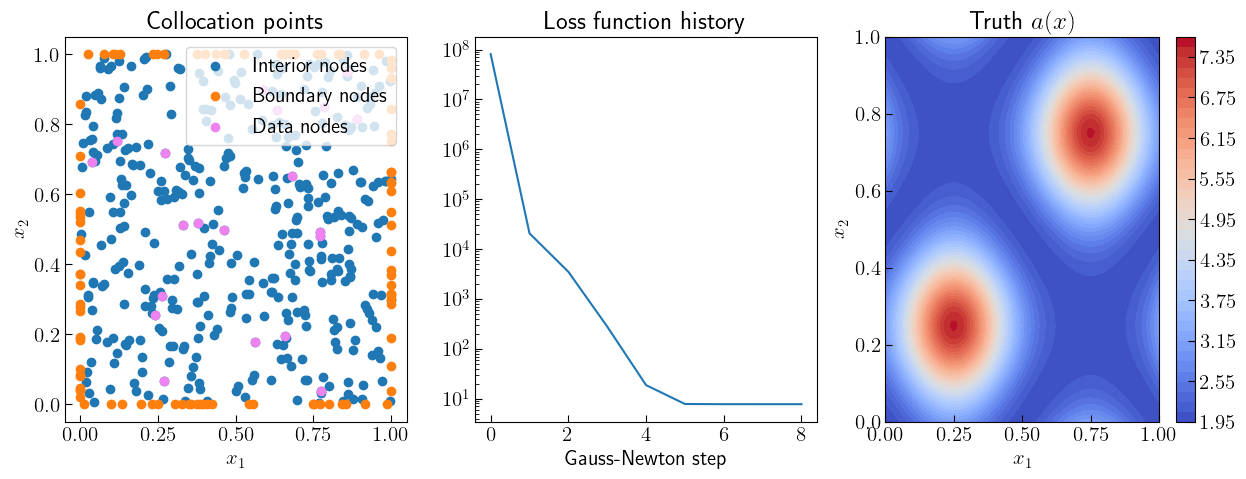

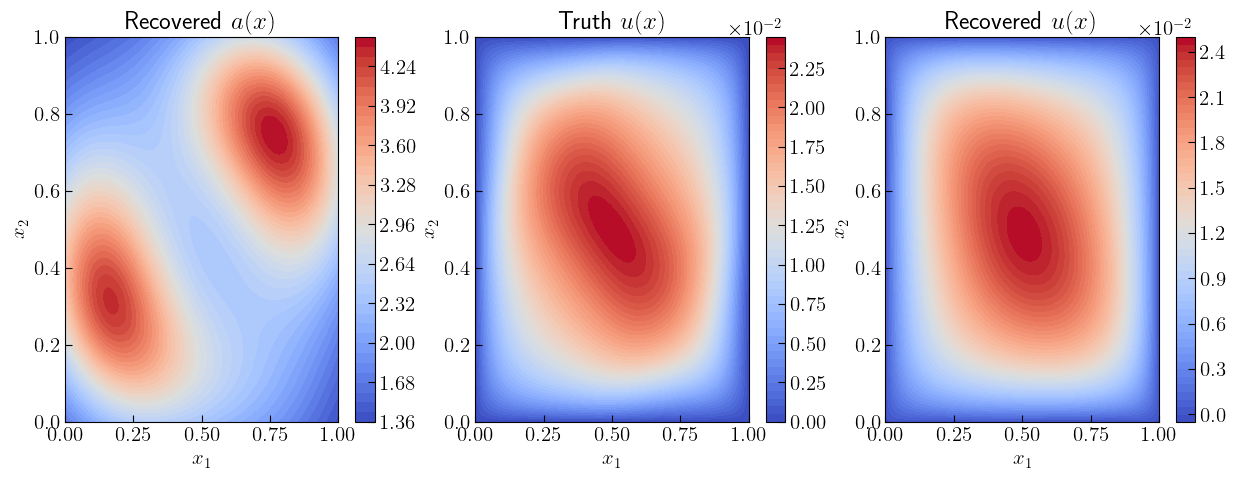

In [16]:
import matplotlib.ticker as ticker

fsize = 15
tsize = 15
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))

fig = plt.figure(figsize=(15,5))
fig.tight_layout()

# plot the collocation pts
ax = fig.add_subplot(131)
ax.scatter(X_domain_tot[range(N_domain_tot), 0], X_domain_tot[range(N_domain_tot), 1], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 0], X_boundary_tot[range(N_boundary_tot), 1], label='Boundary nodes')
ax.scatter(X_domain_tot[data_index_tot, 0], X_domain_tot[data_index_tot, 1], color='violet', label='Data nodes')
ax.legend(loc="upper right")
plt.title('Collocation points')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

ax = fig.add_subplot(132)
plt.plot(onp.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.xticks([0,2,4,6,8])
plt.title('Loss function history')
plt.xlabel('Gauss-Newton step')

ax = fig.add_subplot(133)
a_true_contourf=ax.contourf(XX, YY, ZZ_a, 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Truth $a(x)$')
fig.colorbar(a_true_contourf, format=fmt)
plt.show()

fig = plt.figure(figsize=(15,5))
fig.tight_layout()

ax = fig.add_subplot(131)
a_contourf=ax.contourf(XX, YY, onp.exp(extended_a), 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Recovered $a(x)$')
fig.colorbar(a_contourf, format=fmt)

ax = fig.add_subplot(132)
u_true_contourf=ax.contourf(XX, YY, u_true, 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Truth $u(x)$')
fig.colorbar(u_true_contourf, format=fmt)


ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, extended_u, 50, cmap=plt.cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Recovered $u(x)$')
fig.colorbar(u_contourf, format=fmt)

plt.show()

In [18]:
# store data
# onp.savez('Darcy_flow_demon.npz', XX=XX, YY=YY, extended_u=extended_u, u_true=u_true, ZZ_a=ZZ_a, extended_a=extended_a, X_domain_tot=X_domain_tot, X_boundary_tot=X_boundary_tot, data_index_tot=data_index_tot, max_iter=max_iter, J_hist=J_hist)